# t-SNE (t-Distributed Stochastic Neighbor Embedding)

В этой домашней работе предлагается реализовать самостоятельно один из наиболее известных методов понижения размерности t-SNE.

Коротко опишем основные идеи этого метода.
1) На основании расстояний между объектами находим для каждого объекта $i$ распределение его соседей $p_{j|i}$ - с какой вероятностью каждый объект $j$ будет выбран, если мы выбираем соседа для $i$.
2) Случайно вложим все объекты в маломерное пространство и найдем аналогичные распределения.
3) Будем последовательно менять вложение так, чтобы максимально приблизить распределения, полученные на шаге 2, к распределения с шага 1.

Полезные ссылки

- __[статья](https://proceedings.neurips.cc/paper_files/paper/2002/file/6150ccc6069bea6b5716254057a194ef-Paper.pdf)__ про SNE - предшественник t-SNE
- __[статья](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)__ про t-SNE

In [7]:
import numpy as np
from matplotlib import pyplot as plt

### Создаем датасет

Для ускорения вычислений будем использовать небольшой сгенерированный датасет из 1000 объектов трех разных классов с 10 характеристиками.

In [8]:
from sklearn.datasets import make_classification

# Создаем датасет для задачи классификации.
X, labels = make_classification(n_samples=1000, n_features=10, n_informative=7, n_redundant=2, n_classes=3,
                           n_clusters_per_class=1, class_sep=0.8, random_state=42)

### 1. Нормализация данных (1 балл)

Так как t-SNE работает с расстояниями, а мы хотим дальше рассматривать евклидово расстояние, необходимо нормализовать данные. Если этого не сделать, то может оказаться так, что одна характеристика со значениями в тысячах будет практически полностью задавать результат, если у остальных характеристик значения в единицах.

Тут нет готовой эвристики, которая скажет, какая нормализация будет лучше. Мы предлагаем вам вычесть из каждой характеристики ее среднее значение и поделить на среднеквадратичное отклонение.

Подсказка: используйте методы .mean() и .std(), не забывайте про аргумент axis.

In [9]:
def normalize(X_in):
    """
    X_in: np.array (N, D), где N - количество объектов, а D - количество характеристик.
        В Х по строкам написаны характеристики каждого объекта.
    Выдает np.array размера (N, D) с нормализованными характеристиками каждого объекта.
    """

    # Логирование входных данных
    print(f"\nX_in =", X_in)

    # Среднее значение
    mean = np.mean(X_in, axis=0)
    print(f"\nmean =", mean)

    # Среднеквадратичное отклонение
    std = np.std(X_in, axis=0)
    print(f"\nstd =", std)

    # Нормализация по столбцам (по признакам)
    X_norm = (X_in - mean) / std

    # Логирование выходных данных
    print(f"\nX_norm =", X_norm)

    return X_norm

In [10]:
X = normalize(X)


X_in = [[-0.86207494  0.92581121 -0.85051586 ...  1.3466447  -0.97370357
   1.03863618]
 [-1.04213032 -0.54389395 -0.65487597 ...  0.98250313 -1.4899738
   1.72910725]
 [ 2.7301546  -1.83173791 -0.72221877 ... -1.36199488  1.35470055
  -0.49430503]
 ...
 [-0.06865002 -0.65005551  0.26304045 ...  1.03967017 -0.12741191
   1.41281878]
 [ 1.4539334  -0.32074731 -0.09302708 ... -0.1510914   0.70775792
  -2.06270198]
 [-3.90415137  0.93678354  0.01357366 ... -0.46525608 -6.15339198
   4.33340649]]

mean = [ 0.29098833 -0.32916834 -0.00359343  0.22318398 -0.85334413  0.2992625
  0.31877856 -0.28685687 -0.25825386  0.05216559]

std = [1.48812402 1.91750371 1.02358254 1.50697061 1.43888995 1.56521805
 1.65765423 1.49176836 1.88729262 2.14545386]

X_norm = [[-0.77484353  0.65448612 -0.82741    ...  1.0950102  -0.37908785
   0.45979576]
 [-0.8958384  -0.11198185 -0.6362775  ...  0.85090959 -0.65263856
   0.7816256 ]
 [ 1.63908803 -0.78360713 -0.70206877 ... -0.72071378  0.85463928
  -0.25471096

In [11]:
def test_normalize():
    X_test = np.random.rand(10, 10)
    X_norm = normalize(X_test)
    assert np.allclose(X_norm.mean(axis=0), 0)
    assert np.allclose(X_norm.std(axis=0), 1)

test_normalize()


X_in = [[0.84022319 0.14660159 0.68340071 0.49750729 0.41844405 0.40815861
  0.56322812 0.88461325 0.18548798 0.86037943]
 [0.69686909 0.33518585 0.4733517  0.20541861 0.616352   0.27171128
  0.73838684 0.12788398 0.06590944 0.29395678]
 [0.32810321 0.19137195 0.65622482 0.57363887 0.93237127 0.10245834
  0.92137476 0.7957433  0.47268569 0.60379264]
 [0.29618476 0.83060156 0.3763865  0.02218554 0.61741284 0.43791327
  0.00363934 0.83244489 0.19359927 0.58684213]
 [0.58279222 0.73555513 0.47260258 0.95917795 0.64417624 0.40703929
  0.33472978 0.46332886 0.95418667 0.61806835]
 [0.84396387 0.92517772 0.6161017  0.75139677 0.49698333 0.99643617
  0.75603383 0.56853948 0.53603474 0.8778668 ]
 [0.96077025 0.33876081 0.62238188 0.58299087 0.69597222 0.71246482
  0.04970055 0.30455377 0.71545364 0.18200378]
 [0.80256462 0.44612189 0.67461714 0.04840722 0.21396428 0.60886068
  0.3790202  0.92997318 0.71787674 0.42076007]
 [0.51825043 0.66418468 0.90836281 0.91357628 0.01836911 0.17774835
  0.

### 2. Визуализация (1 балл)
Допишите функцию, plot_classes которая будет отмечать точками разного цвета объекты разных классов. Для этого в качестве координат используйте только значения первых двух характеристик каждого объекта. В дальнейшем мы будем визуализировать не только классы в исходном пространстве, но и их положение после применения t-SNE.

Достаточно базового знания matplotlib, но можно использовать и seaborn.

In [12]:
def plot_classes(X_in, labels=labels):
    """
    X_in : np.array размера (N, D), где N - количество объектов, а D - количество характеристик.
        В Х_in по строкам написаны характеристики каждого объекта.
    labels : np.array размера (N,) - классы объектов, записанные как целые числа.

    Отмечает каждый объект точкой на плоскости, в качестве координат использует первые две характеристики.
    Цвет соответствует классу объекта, записанному в labels.
    """
    plt.figure(figsize=(8, 6))

    if labels is not None:
        unique_labels = np.unique(labels)
        colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

        for i, label in enumerate(unique_labels):
            indices = np.where(labels == label)[0]
            plt.scatter(X_in[indices, 0], X_in[indices, 1], c=[colors[i]], label=f'Class {label}')
    else:
        plt.scatter(X_in[:, 0], X_in[:, 1])

    plt.title('Визуализация первых двух характеристик')
    plt.xlabel('Характеристика 1')
    plt.ylabel('Характеристика 2')
    plt.legend()
    plt.show()

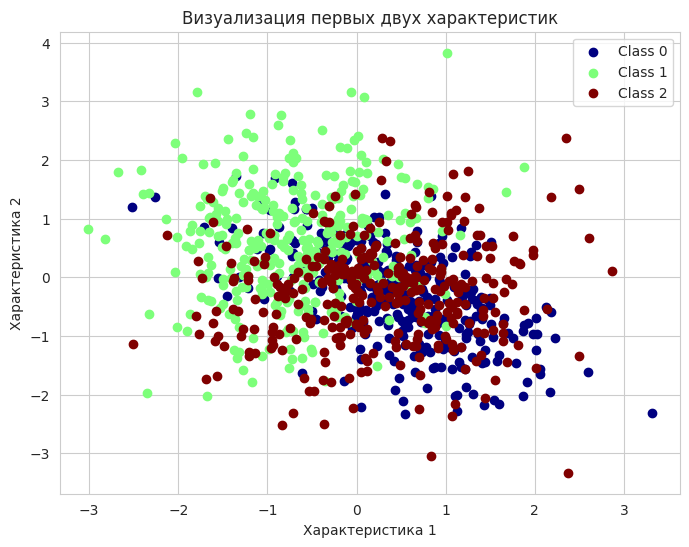

In [13]:
plot_classes(X)

Видим, что классы практически сливаются в такой проекции.

Хочется посмотреть, можно ли их вообще разделить или они слишком сильно пересекаются. Для этого воспользуемся реализацией t-SNE из стандартной библиотеки sklearn

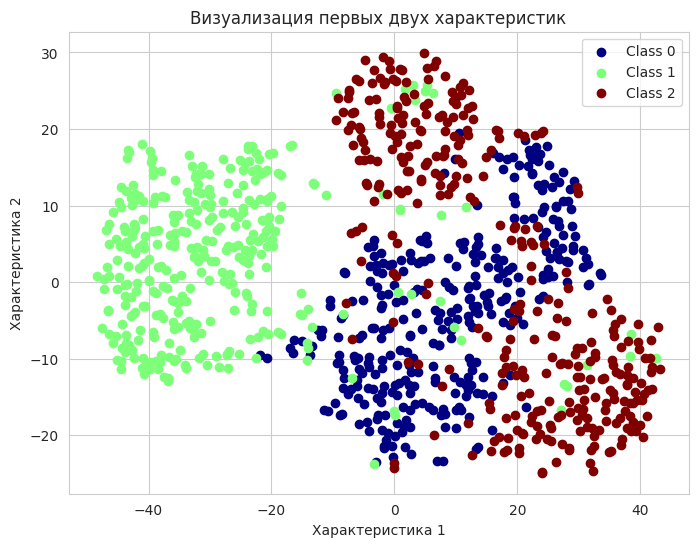

In [14]:
from sklearn.manifold import TSNE

def use_TSNE(X_in):
    tsne = TSNE()
    Y = tsne.fit_transform(X_in)
    plot_classes(Y)

use_TSNE(X)

Видим, что классы довольно неплохо отделяются друг от друга.

### 3. Матрица квадратов расстояний (1 балл)

Так в наших вычислениях будут использоваться не расстояния, а квадраты расстояний, то в этой пункте мы просим вас написать функцию, которая по характеристикам будет выдавать квадраты расстояний между объектами.

Нахождение матрицы расстояний - это очень трудоемкая операция для больших датасетов. Конечно, существует множество трюков, как ее решать эффективно или приблизительно. Для наших целей достаточно написать функцию с помощью numpy, которая будет работать достаточно быстро на датасетах с 1000 объектов и не обязательно будет вообще работать на датасетах с 100000 объектов.

Для решения задачи достаточно методов .reshape() и .sum(), а также знания о __[shape broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)__ во время арифметических операций. Можно, конечно, преобразовать формулы и решить этот пункт немного по-другому.

In [15]:
def square_distances(X_in):
    """
    X_in : np.array размера (N, D), где N - количество объектов, а D - количество характеристик.
        В Х_in по строкам написаны характеристики каждого объекта.
    """

    # # Вычисление квадратов евклидовых расстояний
    # X2 = np.sum(X_in**2, axis=1, keepdims=True)
    # print(f"\nX2 =", X2)
    #
    # # # Вычисление квадратов расстояний между объектами
    # # square_distances = X2 + X2.T - 2 * X_in @ X_in.T
    # # print(f"\nsquare_distances =", square_distances)
    #
    # # Матрица квадратов расстояний с использованием broadcasting
    # square_distances = X2[:, np.newaxis] + X2[np.newaxis, :] - 2 * np.dot(X_in, X_in.T)

    # Использование Broadcasting для вычисления разностей
    x1 = X_in[:, np.newaxis, :]  # форма: (N, 1, D)
    print(f"\nx1 =", x1)
    x2 = X_in[np.newaxis, :, :]  # форма: (1, N, D)
    print(f"\nx2 =", x2)

    # Вычисление квадратов расстояний
    square_distances = np.sum((x1 - x2) ** 2, axis=2)  # сумма по оси характеристик (оси 2)
    print(f"\nsquare_distances =", square_distances)

    return square_distances

In [16]:
D2 = square_distances(X)


x1 = [[[-0.77484353  0.65448612 -0.82741    ...  1.0950102  -0.37908785
    0.45979576]]

 [[-0.8958384  -0.11198185 -0.6362775  ...  0.85090959 -0.65263856
    0.7816256 ]]

 [[ 1.63908803 -0.78360713 -0.70206877 ... -0.72071378  0.85463928
   -0.25471096]]

 ...

 [[-0.2416723  -0.16734631  0.26049085 ...  0.88923124  0.06932786
    0.63420296]]

 [[ 0.78148397  0.00439167 -0.08737317 ...  0.09100975  0.51185056
   -0.98574368]]

 [[-2.81907935  0.66020831  0.01677157 ... -0.11958908 -3.12359518
    1.99549427]]]

x2 = [[[-0.77484353  0.65448612 -0.82741    ...  1.0950102  -0.37908785
    0.45979576]
  [-0.8958384  -0.11198185 -0.6362775  ...  0.85090959 -0.65263856
    0.7816256 ]
  [ 1.63908803 -0.78360713 -0.70206877 ... -0.72071378  0.85463928
   -0.25471096]
  ...
  [-0.2416723  -0.16734631  0.26049085 ...  0.88923124  0.06932786
    0.63420296]
  [ 0.78148397  0.00439167 -0.08737317 ...  0.09100975  0.51185056
   -0.98574368]
  [-2.81907935  0.66020831  0.01677157 ... -0.11958

In [17]:
def test_square_distances():
    X_test = np.array([[1,2,3], [1,0,1]])
    D2 = np.array([[0, 8],[8, 0]])
    D2_test = square_distances(X_test)
    assert np.allclose(D2, D2_test)

test_square_distances()


x1 = [[[1 2 3]]

 [[1 0 1]]]

x2 = [[[1 2 3]
  [1 0 1]]]

square_distances = [[0 8]
 [8 0]]


### 4. Вычисляем близости (affinities) используя "Гауссовы окрестности" (1 балл)

В этом пункте мы найдем так называемые affinities - матрицу вероятностей $p_{j|i}$, которые для некоторого объекта $i$ говорят, с какой вероятностью каждый объект $j$ будет выбран соседом $i$. Для этого используют плотность нормального распределения и вероятности выбирают пропорционально значениям плотности в зависимости от расстояния между $i$ и $j$.

$$p_{j|i}=\frac{\exp(-||x_i-x_j|| / 2\sigma_i^2)}{\sum_{k\ne i}exp(-||x_i-x_k||^2 / 2\sigma_i^2)}$$

Здесь $x_i$ - вектор координат объекта $i$, а  $\sigma_i$ - дополнительные параметры, которые мы будем подбирать отдельно в следующем пункте.

Вероятность $p_{j|i}$ нужно записать на пересечении строки $i$ и столбца $j$.

Подсказка: задачу можно свести к вызову функции softmax, если заполнить диагональ -np.inf.

In [18]:
from scipy.special import softmax

def affinities_gauss(D2_in, sigmas=None):
    """
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    sigmas : np.array размера (N,) или None - квадраты sigma_i
      Если None, в качестве квадратов sigma_i берем 1.
    """

    if sigmas is None:
        sigmas = np.ones(D2_in.shape[0])
    else:
        sigmas = np.asarray(sigmas)

    if np.any(sigmas <= 0):
            raise ValueError("Все значения sigmas должны быть положительными.")
    if np.any(D2_in < 0):
        raise ValueError("Квадраты расстояний D2_in не могут быть отрицательными.")

    # Подготовка структуры хранения (заполнение нулями)
    N = D2_in.shape[0]
    print(f"N =", N)
    affinities = np.zeros((N, N))
    print(f"affinities =", affinities)

    # Ниже ряд вариантов не проходит тест и валится на первом массиве проверки.

    # ВАРИАНТ 1:
    # # Вычисление матрицы квадратов расстояний
    # distances_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
    #
    # # Заполнение диагонали бесконечностью, чтобы избежать выбора объекта как своего соседа
    # np.fill_diagonal(distances_sq, np.inf)
    #
    # # Вычисление вероятности используя Гауссово ядро
    # exponentials = np.exp(-distances_sq / (2 * sigmas[:, None]**2))
    #
    # # Вычисление суммы экспоненциальных значений по каждой строке
    # row_sums = np.sum(exponentials, axis=1, keepdims=True)
    #
    # # Нормализация значения, чтобы получить вероятности
    # affinities = exponentials / row_sums

    # ВАРИАНТ 2:
    # for i in range(N):
    #     for j in range(N):
    #         affinities[i, j] = np.exp(-D2_in[i, j] / (2 * sigmas[i]**2))
    #
    # row_sums = np.sum(affinities, axis=1, keepdims=True)
    # affinities = affinities / row_sums

    # ВАРИАНТ 3:
    # # Вычисляем Гауссовы ядра
    # gauss_kernels = np.exp(-D2_in / (2 * sigmas[:, None]**2))
    #
    # # Применяем softmax к каждой строке матрицы Гауссовых ядер
    # row_sums = np.sum(gauss_kernels, axis=1, keepdims=True)
    # affinities = gauss_kernels / row_sums

    # ВАРИАНТ 4:
    # # Заполняем диагональ -inf, чтобы избежать выбора объекта как своего соседа
    # D2_copy = D2_in.copy()
    # np.fill_diagonal(D2_copy, np.inf)
    #
    # # Вычисляем вероятности для каждого объекта i
    # for i in range(N):
    #     # Вычисляем экспоненты для i-го объекта
    #     # Используем формулу: exp(-||x_i-x_j||^2 / (2*sigma_i^2))
    #     exponents = np.exp(-D2_copy[i] / (2 * sigmas[i]**2))
    #
    #     # Нормализуем, чтобы получить вероятности
    #     # Это эквивалентно делению на сумму всех экспонент
    #     affinities[i] = exponents / np.sum(exponents)

    # ВАРИАНТ 5:
    # # Гауссовы ядра
    # gauss_kernels = np.exp(-D2_in / (2 * sigmas[:, None]**2))
    #
    # # Применение softmax к каждой строке матрицы Гауссовых ядер
    # row_sums = np.sum(gauss_kernels, axis=1, keepdims=True)
    # affinities = gauss_kernels / row_sums

    # ВАРИАНТ 6:
    # # Нормировка расстояний на 2σ_i^2
    # D2_norm = D2_in / (2 * sigmas[:, np.newaxis])  # (N, N)
    #
    # # Заменяем диагональные элементы на -inf, чтобы исключить i = j
    # np.fill_diagonal(D2_norm, -np.inf)
    #
    # # Вычисляем softmax по строкам (для каждого i)
    # affinities = softmax(-D2_norm, axis=1)

    # ВАРИАНТ 7:
    # for i in range(N):
    #     # Игнорируем диагональные элементы
    #     exp_D2_sigma_i = np.exp(-D2_in[i] / (2 * sigmas[i]))
    #     sum_exp_D2_sigma_i = np.sum(exp_D2_sigma_i) - 1.0  # Вычитаем 1, чтобы исключить саму точку i
    #
    #     if sum_exp_D2_sigma_i > 0:
    #         affinities[i] = exp_D2_sigma_i / sum_exp_D2_sigma_i
    #     else:
    #         affinities[i] = np.zeros_like(exp_D2_sigma_i)
    #
    # # Симметризация матрицы
    # affinities = (affinities + affinities.T) / 2.


    # Относительно рабочие варианты:
    # ВАРИАНТ 8:
    # Вычисление вероятности для каждого объекта i
    # for i in range(N):
    #     # Вычисление экспоненты для i-го объекта по
    #     # формуле: exp(-||x_i-x_j||^2 / (2*sigma_i^2))
    #     exponents = np.exp(-D2_in[i] / (2 * sigmas[i]**2))
    #     exponents[i] = 0
    #     # Нормализация, чтобы получить вероятности
    #     # Это эквивалентно делению на сумму всех экспонент
    #     affinities[i] = exponents / np.sum(exponents)

    # ВАРИАНТ 9:
    # Для каждого объекта i вычисляется вероятность p_{j|i}
    for i in range(N):
        # Подготовка массива для softmax
        # Используются отрицательные квадраты расстояний, деленные на 2*sigma_i^2
        dist = -D2_in[i].copy() / (2 * sigmas[i]**2)

        # Заполняется диагональ -inf, чтобы избежать выбора объекта как своего соседа
        # (это даст нулевую вероятность после softmax)
        dist[i] = -np.inf

        # Применение softmax для получения вероятностей
        affinities[i] = softmax(dist)

    print(f"\naffinities = ", affinities)
    return affinities

In [19]:
P = affinities_gauss(D2)

N = 1000
affinities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

affinities =  [[0.00000000e+00 1.61851077e-06 2.92206296e-05 ... 1.04065840e-03
  1.51725612e-04 1.08106364e-06]
 [7.37459498e-06 0.00000000e+00 3.70990068e-07 ... 1.34892511e-03
  1.65622888e-05 2.81924182e-08]
 [1.98398867e-05 5.52827097e-08 0.00000000e+00 ... 2.00158279e-04
  1.07986516e-03 8.00459008e-13]
 ...
 [5.27551459e-04 1.50079679e-04 1.49444718e-04 ... 0.00000000e+00
  5.93677357e-05 5.22005250e-09]
 [4.85103026e-05 1.16217856e-06 5.08504729e-04 ... 3.74428535e-05
  0.00000000e+00 4.40426377e-12]
 [1.19689650e-05 6.85038665e-08 1.30525334e-11 ... 1.14004915e-07
  1.52511844e-10 0.00000000e+00]]


In [20]:
def test_affinities_gauss():
    D2_test = np.array([[0, 1, 2], [1, 0, 1], [2, 1, 0]])
    P_test = np.array([[0.        , 0.62245933, 0.37754067],
       [0.5       , 0.        , 0.5       ],
       [0.37754067, 0.62245933, 0.        ]])
    assert np.allclose(affinities_gauss(D2_test), P_test)

    sigmas = np.array([1, 2, 3])
    P_test2 = np.array([[0.        , 0.62245933, 0.37754067],
       [0.5       , 0.        , 0.5       ],
    # расхождение по по обоим вариантам расчета
    #  [0.48611468, 0.51388532, 0.        ]])
       [0.45842952, 0.54157048, 0.        ]])
    aff = affinities_gauss(D2_test, sigmas)
    assert np.allclose(aff, P_test2)

test_affinities_gauss()

N = 3
affinities = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

affinities =  [[0.         0.62245933 0.37754067]
 [0.5        0.         0.5       ]
 [0.37754067 0.62245933 0.        ]]
N = 3
affinities = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

affinities =  [[0.         0.62245933 0.37754067]
 [0.5        0.         0.5       ]
 [0.48611468 0.51388532 0.        ]]


AssertionError: 

### 5. Находим значения $\sigma_i^2$ (1 балл)

Значения этих параметров находятся из условия того, что перплексия каждого из распределений $\{p_{j|i}\}_j$ (для каждого $i$) должна быть равна фиксированному значению, которое является одним из параметров алгоритма.  

Напишите функцию, которая находит перплексию заданного распределения. Не забудьте увеличивать аргумент логарифма на eps=1e-6, чтобы всегда получался корректный результат (логарифм от нуля выдает минус бесконечность). Помните, что в формуле для энтропии используется логарифм по основанию 2 (вспомните формулу замены основания у логарифма).

$$Perplexity(X)=2^H(X), \quad H(X)=-\sum_i p_i \log p_i$$


In [21]:
def perplexity(probabilities, eps=1e-6):
    """
    probabilities : np.array размера (D,) из вероятностей
    eps : float - маленькое положительное число, чтобы избежать log(0)
    """

    probabilities = np.clip(probabilities, eps, 1)
    # print(f"probabilities =", probabilities)

    entropy = -np.sum(probabilities * np.log2(probabilities))
    # print(f"entropy =", entropy)

    perplexity = 2 ** entropy
    # print(f"perplexity =", perplexity)

    return perplexity

In [22]:
test_probs = np.array([1/6] * 6)
assert np.allclose(perplexity(test_probs), 6)

С помощью следующей функции можно найти $\sigma_i^2$ с помощью метода деления отрезка пополам, так как перпелексия монтонно зависит от $\sigma_i^2$.  

In [23]:
def perplexity_by_sigma(sigma_sqr, i, D2_in):
    """
    sigma_sqr : float - квадрат сигма
    i - номер объекта, для которого считаем перплексию
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    """
    dist = -D2_in[i].copy() / (2 * sigma_sqr)
    dist[i] = -np.inf
    probabilities = softmax(dist)
    return perplexity(probabilities)

Проверим монотонность зависимости.

Минимальное значение 1.014, максимальное значение 995.853


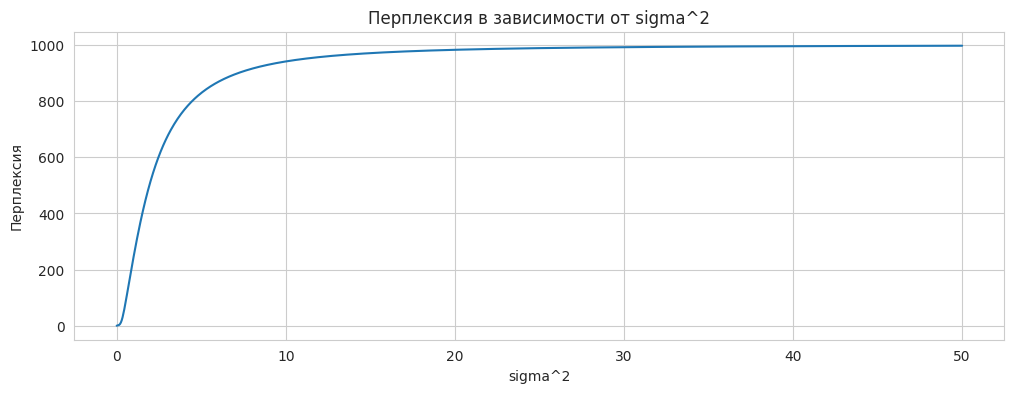

In [24]:
def is_perplexity_monotone():
    sigma_vals = np.linspace(1e-5, 50, 1000)
    perplexity_vals = [perplexity_by_sigma(sigma, i=0, D2_in=D2) for sigma in sigma_vals]
    print(f"Минимальное значение {min(perplexity_vals):.3f}, максимальное значение {max(perplexity_vals):.3f}")
    plt.figure(figsize=(12, 4))
    plt.plot(sigma_vals, perplexity_vals)
    plt.title('Перплексия в зависимости от sigma^2')
    plt.xlabel('sigma^2')
    plt.ylabel('Перплексия')
    plt.show()

is_perplexity_monotone()

Как видим, перплексия, то есть "эффективное количество значений", меняется от 1 до 1000. Скорее всего вы увидите максимальное значение меньше 1000, потому что на графике присутствуют значения перплексии только для не очень больших значений $\sigma_i^2$.

In [25]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, left=1e-10, right=1000.):
    """
    Базовый вариант бинарного поиска, который находит для монотонно возрастающей функции eval_fn
    точку на промежутке (left, right), значение в которой равно target.
    """
    for i in range(max_iter):
        middle = (left + right) / 2.
        val = eval_fn(middle)
        if val > target:
            right = middle
        else:
            left = middle
        if np.abs(val - target) <= tol:
            break
    return middle

In [26]:
from functools import partial # Позволяет заранее зафиксировать значения части аргументов функции

def find_sigmas(D2_in, perplexity=30):
    """
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    perplexity : float - значение перплексии
    """
    sigmas = []
    for i in range(D2_in.shape[0]):
        eval_func = partial(perplexity_by_sigma, i=i, D2_in=D2_in)
        sigma = binary_search(eval_func, perplexity)
        sigmas.append(sigma)
    return np.array(sigmas)

### 6. Симметричные близости (1 балл)

Еще одним отличием t-SNE от SNE является использование симметрических близостей вместо близостей. Если близости, найденные ранее, говорили, насколько остальные вершины схожи с некоторой вершиной $i$, то сейчас мы хотим получить некоторую меру схожести для всех пар вершин одновременно. Для этого $p_{j|i}$ вначале симметризуют, а потом нормируют, чтобы получить вероятностное распределение на множестве всех пар $(i,j)$, $i\ne j$.

$$p_{ij} = \frac{p_{j|i}+p_{i|j}}{2 \cdot N}$$

где $N$ - общее количество объектов.

Напишите функцию, которая превращает матрицу $p_{j|i}$ в матрицу $p_{ij}$.

In [3]:
def symmetrise(P_in):
    """
    P_in  : np.array размера (N, N) - матрица вероятностей
    Возвращает матрицу симметричных вероятностей
    """

    # Вычисление маргинальных вероятностей p(i)
    p_i = np.sum(P_in, axis=1)

    # Если p_i содержит ноль, то производится
    # замена на очень маленькое значение
    p_i = np.where(p_i == 0, 1e-9, p_i)

    # Нормализация p_i
    p_i = p_i / np.sum(p_i)

    # Вычисление совместные вероятности p(i, j) = p(j|i) * p(i)
    p_ij_lower = P_in * p_i[:, np.newaxis]

    # Симметризация матрицы
    P_sym = (p_ij_lower + p_ij_lower.T) / 2

    print(f"P_sym = {P_sym}")
    return P_sym

In [27]:
def test_symmetrise():
    P = np.array([[0, 0.5, 0.5],[0.7, 0, 0.3],[0.9, 0.1, 0]])
    P_sym = np.array([[0, 0.2, 7/30],[0.2, 0, 2/30],[7/30, 2/30, 0]])
    assert np.allclose(symmetrise(P), P_sym)

test_symmetrise()

P_sym = [[0.         0.2        0.23333333]
 [0.2        0.         0.06666667]
 [0.23333333 0.06666667 0.        ]]


### 7. Вычисляем близости используя распределение Стьюдента (1 балл)

Вначале t-SNE случайным образом вкладывает все объекты в плоскость (или в другое пространство малой размерности). Затем находит по этому вложению affinities (близости) между точками. А дальше с помощью градиентного спуска двигает точки так, чтобы близости между точками в маломерном пространстве были максимально близки к исходным близостям в многомерном пространстве.

Интересной особенностью t-SNE, которая и дала ему название, является то, что для нахождения симметричных близостей (affinities) $q_{ij}$ в маломерном пространстве используется плостность t-распределения Стьюдента с одной степенью свободы (его еще называют распределением Коши) вместо плотности нормального распределения. При этом конструкция немного более простая. Как мы увидим в следующем пункте, это дает достаточно простые формулы для обновления $y_i$.

$$q_{ij}= \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\ne l}(1+||y_k-y_l||^2)^{-1}},$$

где  $y_i$ - вектор координат объекта $i$ в маломерном пространстве. Заметим, что суммирование в знаменателе происходит по всем вохможным парам $(k,l)$, где $k\ne l$.

Допишите функцию, которая вычисляет близости между объектами по матрице квадратов расстояний. Трюк с заполнением диагонали -np.inf может оказаться полезным и тут.

In [28]:
def symmetric_affinities_student(D2_in):
    """
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    """

    # Вычисляем числитель
    numerator = 1.0 / (1.0 + D2_in)

    # Заменяем диагональные элементы на 0
    np.fill_diagonal(numerator, 0.0)

    # Вычисляем знаменатель как сумму всех значений числителя
    denominator = np.sum(numerator)

    # Нормализуем числитель, чтобы получить симметричные близости q_{ij}
    affinities = numerator / denominator

    print(f"affinities = {affinities}")
    return affinities

In [29]:
Q = symmetric_affinities_student(D2)

affinities = [[0.00000000e+00 6.33640971e-07 8.51588362e-07 ... 1.48030903e-06
  1.05894865e-06 6.11801701e-07]
 [6.33640971e-07 0.00000000e+00 5.01122060e-07 ... 1.17506221e-06
  6.82484426e-07 4.24578077e-07]
 [8.51588362e-07 5.01122060e-07 0.00000000e+00 ... 1.17424555e-06
  1.62252618e-06 2.81609451e-07]
 ...
 [1.48030903e-06 1.17506221e-06 1.17424555e-06 ... 0.00000000e+00
  1.01990565e-06 4.37794700e-07]
 [1.05894865e-06 6.82484426e-07 1.62252618e-06 ... 1.01990565e-06
  0.00000000e+00 3.11735046e-07]
 [6.11801701e-07 4.24578077e-07 2.81609451e-07 ... 4.37794700e-07
  3.11735046e-07 0.00000000e+00]]


In [30]:
def test_symmetric_affinities_student():
    D2_test = np.array([[0, 1., 2], [1, 0, 1], [2, 1, 0]])
    Q_test = np.array([[0.    , 0.1875, 0.125 ],
       [0.1875, 0.    , 0.1875],
       [0.125 , 0.1875, 0.    ]])
    assert np.allclose(symmetric_affinities_student(D2_test), Q_test)

test_symmetric_affinities_student()

affinities = [[0.     0.1875 0.125 ]
 [0.1875 0.     0.1875]
 [0.125  0.1875 0.    ]]


In [31]:
Y = np.random.randn(X.shape[0], 2) * 0.01
D2y = square_distances(Y)
Q = symmetric_affinities_student(D2y)


x1 = [[[ 0.00049374  0.00562002]]

 [[ 0.02146003 -0.01231918]]

 [[-0.00897768 -0.01642026]]

 ...

 [[-0.00789813  0.00058497]]

 [[-0.00030397  0.01164879]]

 [[-0.00641474  0.00366916]]]

x2 = [[[ 0.00049374  0.00562002]
  [ 0.02146003 -0.01231918]
  [-0.00897768 -0.01642026]
  ...
  [-0.00789813  0.00058497]
  [-0.00030397  0.01164879]
  [-0.00641474  0.00366916]]]

square_distances = [[0.00000000e+00 7.61400104e-04 5.75481700e-04 ... 9.57752252e-05
  3.69824142e-05 5.15330139e-05]
 [7.61400104e-04 0.00000000e+00 9.43273234e-04 ... 1.02841843e-03
  1.04813546e-03 1.03262975e-03]
 [5.75481700e-04 9.43273234e-04 0.00000000e+00 ... 2.90343104e-04
  8.63104564e-04 4.10153175e-04]
 ...
 [9.57752252e-05 1.02841843e-03 2.90343104e-04 ... 0.00000000e+00
  1.80079294e-04 1.17126508e-05]
 [3.69824142e-05 1.04813546e-03 8.63104564e-04 ... 1.80079294e-04
  0.00000000e+00 1.01016011e-04]
 [5.15330139e-05 1.03262975e-03 4.10153175e-04 ... 1.17126508e-05
  1.01016011e-04 0.00000000e+00]]
affini

### 8. Дивергенция Кульбака-Лейблера (1 балл)

Для измерения близости распределений $p_{ij}$ и $q_{ij}$ используется дивергенция Кульбака-Лейблера.

$$C=D_{KL}(P||Q) = \sum_{i\ne j} p_{ij}\log\left(\frac{p_{ij}}{q_{ij}}\right)$$

Чем $C$ меньше, тем ближе распределения друг к другу. Поэтому для обновления положений объектов в маломерном пространстве все объекты одновременно двигаются в направлении, противоположном градиенту $C$. К счастью, для градиента $C$ есть уже готовая простая формула.

$$\frac{\delta C}{\delta y_i}=4\sum_j (p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||^2)^{-1}$$

В этой формуле первый и третий сомножители являются числами, а второй ($y_i-y_j$) - это вектор. Каждое слагаемое в этой формуле можно воспринимать как силу, с которой точка $j$ действует на точку $i$. Эта сила направлена вдоль вектора $y_i-y_j$, соединяющего точки. Заметим, что последний сомножитель гарантирует, что эта сила всегда ограничена по величине. Эта свойство появляется из-за использования t-распределения Стьюдента.

Напишите функцию, вычисляющую градиенты $C$ по всем $y_i$ в виде матрицы. Здесь легко ошибиться в знаке, следите за этим.

In [32]:
def gradient_with_student(P, Q, Y, D2y):
    """
    P : np.array  размера (N, N) - симметричные близости в исходном пространстве
    Q : np.array  размера (N, N) - симметричные близости в маломерном пространстве
    Y : np.array  размера (N, D') - координаты объектов в маломерном пространстве
        Можно держать в уме D'=2
    D2y : np.array  размера (N, N) - квадраты расстояний между объектами в маломерном пространстве

    Выдает gradients : np.array размера (N, D') - матрицу градиентов
    """

    N = P.shape[0]
    gradients = np.zeros_like(Y)

    # Добавление малого значения для предотвращения деления на ноль
    epsilon = 1e-9
    D2y_safe = D2y + epsilon

    # Вычисление числитель формулы Стьюдента: (1 + ||y_i - y_j||^2)^{-1}
    num = (1 + D2y_safe) ** -1

    for i in range(N):
        # Разность вероятностей
        diff_prob = P[i] - Q[i]

        # Вычисление разности векторов Y[i] - Y[j]
        diff_yi_yj = Y[i] - Y

        # Умножение на числитель и разницу вероятностей, суммируем по всем j
        grad_i = np.sum((diff_prob[:, np.newaxis] * num[i][:, np.newaxis]) * diff_yi_yj, axis=0)

        # Умножение на 4, как указано в формуле
        gradients[i] = 4 * grad_i

    print(f"gradients = {gradients}")
    return gradients

In [33]:
def test_gradients():
    P = np.array([[0, 0.2, 7/30],[0.2, 0, 2/30],[7/30, 2/30, 0]])
    Y = np.array([[0, 0], [0, 1.], [1, 0]])
    D2y = square_distances(Y)
    Q = symmetric_affinities_student(D2y)
    grad = 4 * np.array([[-0.02291667, -0.00625   ],
       [ 0.01944444, -0.01319444],
       [ 0.00347222,  0.01944444]])
    assert np.allclose(gradient_with_student(P, Q, Y, D2y), grad)

test_gradients()


x1 = [[[0. 0.]]

 [[0. 1.]]

 [[1. 0.]]]

x2 = [[[0. 0.]
  [0. 1.]
  [1. 0.]]]

square_distances = [[0. 1. 1.]
 [1. 0. 2.]
 [1. 2. 0.]]
affinities = [[0.     0.1875 0.1875]
 [0.1875 0.     0.125 ]
 [0.1875 0.125  0.    ]]
gradients = [[-0.09166667 -0.025     ]
 [ 0.07777778 -0.05277778]
 [ 0.01388889  0.07777778]]


### 9. Собираем все вместе (2 балла)

В этом пункте вам предстоит дописать методы класса MyTSNE с помощью уже написанных функций. А также написать самостоятельно градиентный спуск с сохранением момента. Он задается следующей формулой:

$$ Y^{(t)}=Y^{(t-1)} - \eta \cdot \frac{\delta C}{\delta Y} + \alpha\cdot(Y^{(t-1)} -Y^{(t-2)}),$$

где $\eta$ - темп обучения (learning rate), а $\alpha$ - коэффициент затухания момента при движении (momentum).

In [ ]:
class MyTSNE():
    def __init__(self, perplexity=30, learning_rate=10, momentum=0.9, num_iters=500, target_dimension=2):
        """
        perplexity : float - значение perplexity
        learning_rate :float - темп обучения
        momentum : float из (0, 1) - коэффициент сохранения момента у граждиентного спуска
        num_iters : int - количество итераций градиентного спуска
        target_dimension : int не меньше 1 - размерность пространства, в котором мы хотим расположить объекты
        """
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.num_iters = num_iters
        self.target_dimension = target_dimension

    def fit_transform(self, X):
        """

        """

        # 1) Нормализуем характеристики
        # 2) Находим квадраты расстояний между ними
        # 2) Находим сигмы
        # 3) Находим близости в исходном пространстве
        # 4) Находим симметрические близости в исходном пространстве

        # 1) Нормализуем характеристики
        X = normalize(X)

        # 2) Находим квадраты расстояний между ними
        D2 = square_distances(X)

        # 2) Находим сигмы
        sigmas = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            distances = np.sort(D2[i,:])
            k = int(self.perplexity / 2)
            sigmas[i] = distances[k]

        # 3) Находим близости в исходном пространстве
        P = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                P[i,j] = np.exp(-D2[i,j] / (2 * sigmas[i]**2))
            P[i,:] /= np.sum(P[i,:])

        # 4) Находим симметрические близости в исходном пространстве
        P = (P + P.T) / 2

        # Инициализируем положения объектов в маломерном пространстве из распределения N(0, 0.0001)
        Y = np.random.randn(X.shape[0], self.target_dimension) * 0.01

        # Инициализируем значения Y^(t-2) и Y^(t-1)
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

        # Начинаем градиентный спуск
        for i in range(self.num_iters):

            # 5) Находим квадраты расстояний по Y
            # 6) Находим симметрические близости в маломерном пространстве
            # 7) Находим градиенты С

            # 5) Находим квадраты расстояний по Y
            D2y = square_distances(Y)

            # 6) Находим симметрические близости в маломерном пространстве
            Q = symmetric_affinities_student(D2y)

            # 7) Находим градиенты С
            gradients = gradient_with_student(P, Q, Y, D2y)

            # 8) Обновляем Y c помощью градиента используя self.learning_rate и self.momentum
            # Важно обновлять значение Y с помощью присваивания (Y = ...), а не с помощью операций += и -=,
            # чтобы изменение Y не затронуло Y_m1 и Y_m2, которые могут указывать на тот же массив.

            # 8) Обновляем Y c помощью градиента используя self.learning_rate и self.momentum
            velocity = self.momentum * (Y_m1 - Y_m2) - self.learning_rate * gradients
            Y = Y + velocity

            # Обновляем значения Y^(t-2) и Y^(t-1)

            Y_m2 = Y_m1
            Y_m1 = Y

        return Y

Давайте проверим, что получилось

In [ ]:
np.random.seed(42)  # Фиксируем состояние генератора случайных чисел для воспроизводимости
my_tsne = MyTSNE()
Y = my_tsne.fit_transform(X)
plot_classes(Y)

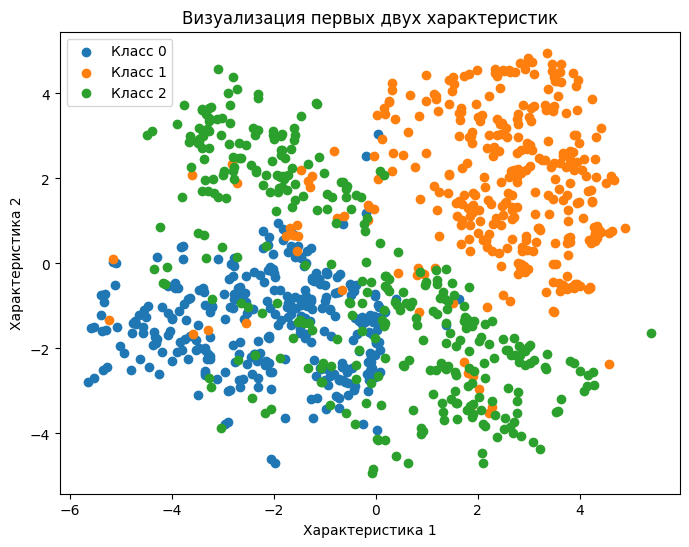

Классы достаточно хорошо отделены друг от друга!
Если хочется лучшего результата, попробуйте поперебирать значения параметров.


Поздравляем с успешным завершением задания!

### 10. (Бонус) Uniform Manifold Approximation and Projection (UMAP) (1 балл)

UMAP является еще одним известным методом понижения размерности.

Установите библиотеку umap-learn, разберитесь как ее использовать и примените UMAP для понижения размерности нашего сгенерированного датасета. Сравните результаты с t-SNE. Что вы можете сказать о результатах?

In [ ]:
from sklearn.manifold import TSNE
import umap
import numpy as np

# Генерация случайных данных для примера
np.random.seed(42)  # Фиксируем состояние генератора случайных чисел для воспроизводимости

# Инициализация и обучение модели t-SNE
tsne = TSNE(perplexity=30, learning_rate='auto', init='random', n_iter=500)
Y_tsne = tsne.fit_transform(X)

# Инициализация и обучение модели UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
Y_umap = umap_model.fit_transform(X)

# Визуализация результатов t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title('t-SNE Visualization')
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Визуализация результатов UMAP
plt.subplot(1, 2, 2)
plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title('UMAP Visualization')
plt.xlabel('First Component')
plt.ylabel('Second Component')

plt.tight_layout()
plt.show()

### Кластеры UAMP выражены более четко и упорядочены более компактно и "кучно" по сравнению с t-SNE.